In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

%load_ext autoreload
%autoreload 2


In [472]:
# Load the cutout of the ACT map

hdu = fits.open('advact_tt_patch.fits')
data = hdu[0].data
hdu.close()

clu_map =np.asarray(data,dtype='float')

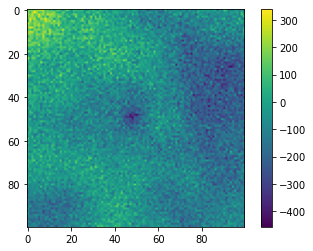

In [117]:
# zoom in and take a look at the source 
clu_map.shape
zoom = clu_map[1950:2050,2950:3050]


plt.imshow(zoom) 
plt.colorbar()
plt.show()

## Part 1

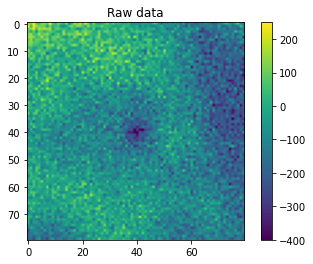

parameter shifts are  [ 3.03838895e+02 -8.82357516e-02 -1.53309061e-01  7.02502544e-01
  1.77470942e+02]
parameter shifts are  [-15.23183136  -0.12507358  -0.23869801   1.39804048  -0.82126918]
parameter shifts are  [ 9.93417029 -0.08122461 -0.09984637  0.52666096 -1.25101967]
parameter shifts are  [ 7.58242166 -0.07042483 -0.11089532  0.26664093 -0.34139733]
parameter shifts are  [ 4.1678189  -0.03756285 -0.06090239  0.13606635 -0.15065441]
parameter shifts are  [ 2.1260449  -0.01766981 -0.03216638  0.0661938  -0.06921245]
parameter shifts are  [ 1.03609193 -0.00785337 -0.01568504  0.03136018 -0.03186309]
parameter shifts are  [ 0.48958835 -0.00349574 -0.00744714  0.01459681 -0.01463252]
parameter shifts are  [ 0.22775748 -0.00156953 -0.00346408  0.00673873 -0.00671354]
parameter shifts are  [ 0.10507073 -0.00071135 -0.00159941  0.00309735 -0.00307708]


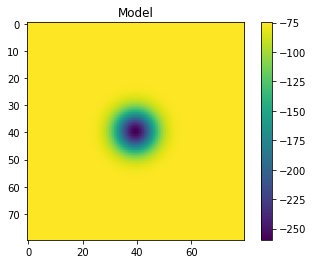

best-fit improvement is  -6034.273364956098
Fit parameters:
amplitude:-185.72397214839953
dx:-0.4338214076739403
dy:-0.7240132032808902
sigma:5.151898115790477
background subtraction:74.78110233903493


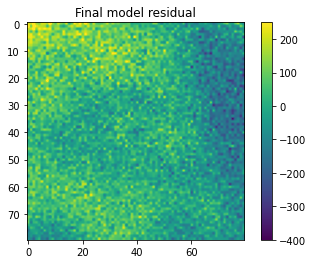

In [623]:
# Define the functions necessary for fitting a 2D Gaussian using Newton's Method

def mygauss(pars,width):
    vec=np.asarray(np.arange(-width,width),dtype='float')
    amp=pars[0]
    dx=pars[1]
    dy=pars[2]
    sig=pars[3]
    back = pars[4]

    xvec=vec-dx
    yvec=vec-dy
    xmat=np.outer(xvec,np.ones(len(xvec)))
    ymat=np.outer(np.ones(len(yvec)),yvec)
    rmat=xmat**2+ymat**2
    model=(np.exp(-0.5*(rmat/sig**2))*amp) - back

    return model

def get_model_derivs(fun,pars,dpar,width):
    model=fun(pars,width)
    npar=len(pars)
    derivs=[None]*npar
    for i in range(npar):
        pp=pars.copy()
        pp[i]=pars[i]+dpar[i]
        m_plus=fun(pp,width)
        pp[i]=pars[i]-dpar[i]
        m_minus=fun(pp,width)
        derivs[i]=(m_plus-m_minus)/(2*dpar[i])
    return model,derivs

def get_model_derivs_ravel(fun,pars,dpar,width):
    model,derivs=get_model_derivs(fun,pars,dpar,width)
    model=np.ravel(model)
    npar=len(pars)
    derivs_out=np.empty([len(model),len(pars)])
    for i in range(npar):
        derivs_out[:,i]=np.ravel(derivs[i])
    return model,derivs_out

def newton(pars,data,fun,width,dpar,niter=10):
    for i in range(niter):
        model,derivs=get_model_derivs_ravel(fun,pars,dpar,width)
        resid=data-model
        lhs=derivs.T@derivs ### ADDD IN NOISE MATRIX ####
        rhs=derivs.T@resid
        shift=np.linalg.inv(lhs)@rhs
        print('parameter shifts are ',shift)
        pars=pars+shift
    return pars
    

# Source
x0=1999
y0=2998

# Snip around the source
width=40
patch=clu_map[x0-width:x0+width,y0-width:y0+width]

plt.imshow(patch,vmin=-400,vmax=250)
plt.colorbar()
plt.title('Raw data')
plt.show()

# Now do a fit using Newton's Method
# Iteratively take steps downhill until converge on best fit parameters
pars=np.asarray([-500,0,0,2,-100],dtype='float')
dpar=np.asarray([1.0,0.01,0.01,0.01,1.0])/10

# Do fit for just the patch
fitp=newton(pars,np.ravel(patch),mygauss,width,dpar)
mymod=mygauss(fitp,width)

plt.imshow(mymod)
plt.colorbar()
plt.title('Model')
plt.show()

fit_chisq=np.sum((patch-mymod)**2/n**2)
print('best-fit improvement is ',chi1-fit_chisq)
print('Fit parameters:')
print(f'amplitude:{fitp[0]}')
print(f'dx:{fitp[1]}')
print(f'dy:{fitp[2]}')
print(f'sigma:{fitp[3]}')
print(f'background subtraction:{fitp[4]}')

plt.imshow(patch-(mymod),vmin=-400,vmax=250)
plt.colorbar()
plt.title('Final model residual')
plt.show()


We can see above that our fit does a decent job in the residual. While there is some slight signal, the SNR of the residual is small. We also get parameters that we would expect, such as an amplitude in the negative hundreds and small dx and dy's as we are fitting the source in the center. The sigma is still a little large, but it is small enough to generally capture the signal. The difficulty with this fit is that the signal is not much greater than the noise, so the fit is poor without including an offset in the gaussian model. Using a better method, such as Levenberg Marquardt, would also result in a better fit.

## Part 2

In [363]:
# Add function for padding 
def pad_map(map):
    map=np.hstack([map,np.fliplr(map)])
    map=np.vstack([map,np.flipud(map)])
    return map

We can calculate the smoothed power spectrum of a given map by convolving the 2D power spectrum with a gaussian kernel. This convolution is done in Fourier space, and is done by taking the inverse fourier transform of the fourier transform of the 2D power spectrum and the gaussian kernel. 

In [611]:
from jons_code import get_gauss_kernel

def estimate_ps(s_map,sig):
    
    # pad the ingoing map 
    padded_map = pad_map(s_map)
    
    # Calculate the power spectrum
    ps = abs(np.fft.fft2(padded_map))**2 
    
    # Define a guassian kernel for smoothing
    gauss_k = get_gauss_kernel(padded_map,sig,norm = True)

    # To smooth need to convolve the two functions which means multiplying in Fourier space
    ps_FT = np.fft.fft2(ps)
    gauss_FT = np.fft.fft2(gauss_k)
    mult = ps_FT * gauss_FT
    
    # Inverse fourier transform to get back to real space
    smooth_ps = np.fft.ifft2(mult) 

    return np.real(smooth_ps)


In [612]:
# Have a look at the smoothed power spectrum for the entire map
s_ps = estimate_ps(clu_map,sig=fitp[3])

# Since the Fourier transform is not centered on zero, have to shift it
s_ps_shift = np.fft.fftshift(s_ps)

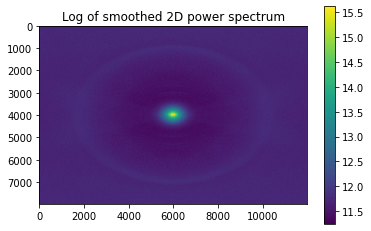

In [613]:
plt.imshow(np.log10(s_ps_shift))
plt.title('Log of smoothed 2D power spectrum')
plt.colorbar()
plt.show()

The above power spectrum is padded, so the dimensions are double the original map.

## Part 3

Write a routine that applies the inverse noise matrix to a map, or $(N^{-1}A)$. This will come in handy when calculating the left and right hand side of the least-squared fitting. 

In [614]:
def filter_map(s_map,ps):
    
    #pad map 
    padded_map = pad_map(s_map)
    
    # solve N^-1 d
    d = np.fft.fft2(padded_map)
    N = ps
    
    # add the correct normalization
    noise_filt = np.fft.ifft2(d/N) * ((padded_map**2).sum())
    
    #un-pad the map 
    noise_filt = noise_filt[:s_map.shape[0],:s_map.shape[1]]
    
    return np.real(noise_filt) 

In [615]:
# Try an example for the entire map 
noise_filt = filter_map(clu_map,s_ps)

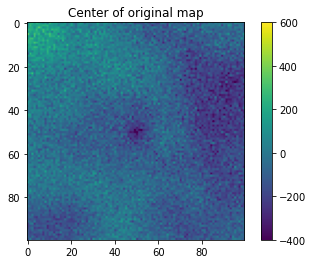

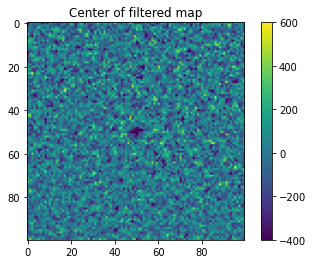

In [616]:
x0=1999
y0=2998


# Snip around the source 
width=50

plt.imshow(clu_map[x0-width:x0+width,y0-width:y0+width],vmin=-400,vmax=600)
plt.title('Center of original map')
plt.colorbar()
plt.show()

patch=noise_filt[x0-width:x0+width,y0-width:y0+width]
plt.title('Center of filtered map')
plt.imshow(patch,vmin=-400,vmax=600)
plt.colorbar()
plt.show()


As expected, the filtered map shows the source surrounded by white noise instead of the correlated noise it was surrounded by in the original map. There is now no structure to the noise like we see in the original map. I have also implemented normalization so that the amplitudes we see in the original map are similar in the filtered map. Without, the amplitude of the filtered map would be reduced by a constant of about $10^{-12}$.

## Part 4

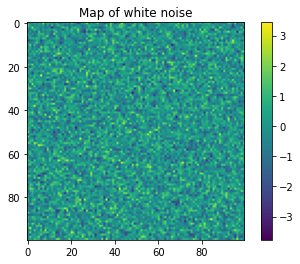

In [619]:
# Make a map of white noise 
wn_map = np.random.randn(100,100)

plt.imshow(wn_map)
plt.title('Map of white noise')
plt.colorbar()
plt.show()

In [620]:
# Run a test on the filter map to ensure it is properly normalized
test_ps = estimate_ps(wn_map,10)
test_filter = filter_map(wn_map,test_ps)

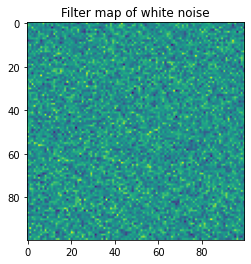

variance of filter map: 0.9993603269470342


In [621]:
plt.imshow(test_filter)
plt.title('Filter map of white noise')
plt.show()
print('variance of filter map:',np.std(test_filter.flatten())**2)


The filtered map of white noise should also be white noise, which we see above. Also, since I used random values pulled from a normal distribution of $\sigma=1$ to make the original map, the variance we would expect from the filter map would be one. I get approximately one for the variance of my filter map, showing again that my filter map function is properly normalized. 

## Part 5

First I wanted to demonstrate that we get the correct normalization for a situation where we know where the cluster is (in this case the cluster in the center). This is not correct for the entire map, since the power spectrum I estimated here is only for the patch, not the entire map. Here I solve the equation $A^TN^{-1}A = (N^{-1}A)^Td$ to show that the amplitude I get from the model that was computed in part 1 on the center patch is close to the actual amplitude, by showing the ratio of the left hand side and the right hand side of the equation is 1. 

In [624]:
patch_ps = estimate_ps(patch,5)
mod_filt = filter_map(mymod,patch_ps)

lhs=np.sum(mod_filt*mymod)

# Following the (N^-1A)^T d definition. I use this one so I can reuse mod_filt.
# This can also be written as A^T (N^-1 d)
rhs=np.sum(mod_filt*(patch))

amp=rhs/lhs
err=1/np.sqrt(lhs)
print('Amp and errors are',amp,err )
print('Amplitude and errors in uK',amp*fitp[0],err*fitp[0] )

Amp and errors are 1.0159561030024007 0.0024229697006356225
Amplitude and errors in uK -188.68740297801438 -0.4500035571972663


As seen above, the amplitude we got from our model is what we expected from the data. This error is so small because the noise is on large scale but signal on small scale in this patch.

Next I will make a gaussian template for the entire map, and use it along with the power spectrum of the enitre map to do cross correlation and make a matched filter map to try and identify additional clusters.

In [625]:
# Make a new template
my_kern_mod = get_gauss_kernel(clu_map, sig=5, norm=False)

# Get the smoothed power spectrum of the entire map
ps = estimate_ps(clu_map,5)

# get the filtered map of the template 
mod_filt = filter_map(my_kern_mod,ps)

Since we now don't know the locations of other clusters in the map, we can use the power of cross correlation to do a least-squares fit of the template with every point in the map and therefor get a map of the amplitudes. We can do the following for different positions:

$ A(x-t)^TN^{-1}A(x-t)m = A(x-t)^TN^{-1}d(x) $

$x' = x-t$

$ A(x')^TN^{-1}A(x')m = A(x')^TN^{-1}d(x'+t) $

$ m = A(x')^TN^{-1}d(x'+t)/A(x')^TN^{-1}A(x') $

We see above that the noise matrix remains the same so we continue to use the power spectrum of the entire map. However, we must do a cross correlation between $(N^{-1}A)$ and $d(x'+t)$. This can be done with the following: 

$cc = IFT(FT(N^{-1}A)* FT(d(x'+t))^*)$



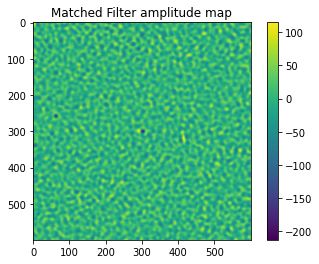

Error of patch: 35.08852259683454


In [629]:
# Left hand side stays the same
lhs = np.sum(mod_filt*my_kern_mod)

# Take the fourier trnasforms for the cross correlations
datft = np.fft.fft2(clu_map)
mod_filtft = np.fft.fft2(mod_filt)

# Do the cross correlation for the rhs
mf_rhs=(np.real(np.fft.ifft2(mod_filtft*np.conj(datft))))

# Solve for the amplitude over the entire map
amp = mf_rhs/lhs

# Zoom in
x0=2000
y0=3000

width=300
plt.imshow(amp[x0-width:x0+width,y0-width:y0+width])
plt.title('Matched Filter amplitude map')
plt.colorbar()
plt.show()

print('Error of patch:',np.std(amp[x0-30:x0+30,y0-30:y0+30]))

We can see above that at the center of the map is the original cluster, with an amplitude we expect. We also see another cluster about 200 pixels away. The low amplitude that is selected out of the matched filter stands out abive the noise.

## Part 6

Looking at the sky around the Abell, the cluster MACSJ0035.4-2015 lies to the right and up at ra $=00h 35m 27.640s$ dec $= -20° 17' 57.68"$. For some reason, my amplitude map shows an incorrect offset in the x direction to where this cluster should lie. However, it does pick it up.